### Metrics and Signatures for Meuse model with M4SE loss function

Models: 
- MTS-LSTM Era5 forcing, HydroMT statics (model 1A), trained on Meuse catchments, new loss fucntino (M4SE)

Results
- Load wflow daily and hourly results for Meuse catchments
- Load MTS-LSTM model results for Meuse catchments
- Load observed streamflow
- Load forcing precipitation timeseries

Plot: 
- timeseries plots for all Meuse catchments

Metrics:
- Load/Calculate peak metrics
- Load metrics and combine with peak metrics

Signatures:
- Load/Calcualte signatures

Comparison:
- Table with mean metrics and sigantures per model, per catchment
- Corellation between signatures based on observed streamflow and modeled streamflow

Flow duratino curves
- normal
- log 

### Imports etc

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from pandas.plotting import autocorrelation_plot, scatter_matrix

import os
import pickle
from collections import defaultdict
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm
from pathlib import Path

from scipy.stats import pearsonr

from neuralhydrology.evaluation.signatures import calculate_signatures, get_available_signatures
from neuralhydrology.evaluation.metrics import calculate_metrics

from peak_magnitude import mean_peak_magnitude


In [26]:
models = ['lstm', 'wflow', 'M4SE', 'obs']  
meuse_dir = 'data/Meuse/'
new_loss_dir = 'data/results/new_loss_Meuse/'

### Data loading
#### load wflow results daily

In [4]:
frequencies = ['1D', '1H']

# seems like observations only reach from 2005 until 2018 (2017 for hourly?)
# start_date = pd.to_datetime('1981-01-01', format='%Y-%m-%d')   # for simulations
start_date = pd.to_datetime('2005-10-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2017-09-30', format='%Y-%m-%d')

catchment_ids_wflow = ['Q_6', 'Q_13', 'Q_701', 'Q_702', 'Q_703']
catchment_ids_obs = [6, 13, 701, 702, 703]

areas = [551.65, 305.82, 162.81, 232.15, 123.91]

In [6]:
# wflow predictions in m3/s
wflow_meuse_sim_d = pd.read_csv('data/Meuse/wflow_output_daily.csv', index_col='time')
wflow_meuse_sim_d = wflow_meuse_sim_d[catchment_ids_wflow] 
# wflow_meuse_sim_d.head()

In [7]:
# df to xarray ds
datasets = []
for catchm in wflow_meuse_sim_d.columns:
    df = wflow_meuse_sim_d.filter([catchm], axis=1)
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.rename({catchm: 'Qsim_m3s'})
    ds['catchments'] = int(catchm.split('_')[-1])
    datasets.append(ds)
    
wflow_sim_d = xr.concat(datasets, dim="catchments")
wflow_sim_d['time'] = pd.to_datetime(wflow_sim_d.time.values)
wflow_sim_d = wflow_sim_d.sel(time=slice(start_date, end_date))

# wflow_sim_d

#### load wflow results hourly

In [8]:
# wflow predictions in m3/s
wflow_meuse_sim_h = pd.read_csv('data/Meuse/wflow_output_hourly.csv', index_col='time')
wflow_meuse_sim_h = wflow_meuse_sim_h[catchment_ids_wflow]
# wflow_meuse_sim_h.head()

In [9]:
# df to xarray ds
datasets = []
for catchm in wflow_meuse_sim_h.columns:
    df = wflow_meuse_sim_h.filter([catchm], axis=1)
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.rename({catchm: 'Qsim_m3s'})
    ds['catchments'] = int(catchm.split('_')[-1])
    datasets.append(ds)
    
wflow_sim_h = xr.concat(datasets, dim="catchments")
wflow_sim_h['time'] = pd.to_datetime(wflow_sim_h.time.values)
wflow_sim_h = wflow_sim_h.sel(time=slice(start_date, end_date))

# wflow_sim_h

#### load Meuse observations

In [11]:
# Meuse observations in m3/s - HOURLY - BELGIAN CATCHMENTS
meuse_obs_h = xr.open_dataset('data/Meuse/qobs_hourly_belgian_catch.nc')
meuse_obs_h  = meuse_obs_h.sel({'catchments': catchment_ids_obs})
meuse_obs_h = meuse_obs_h.sel(time=slice(start_date, end_date))

# Meuse observations in m3/s - DAILY - BELGIAN CATCHMENTS
meuse_obs_d = meuse_obs_h.resample(time='1D').mean()
# meuse_obs_d
# meuse_obs_h

#### load Meuse MTS-LSTM results (daily and hourly) 
- with NSE loss function
- with M4SE loss function

In [14]:
# Q in mm/h
# NSE loss function
with open('data/results/Meuse_regional_MTS-LSTM/test_results.p', 'rb') as f:
    lstm_results = pickle.load(f)
    
# M4SE loss fucntion
with open('data/results/Meuse_new_loss/test_results.p', 'rb') as f:
    new_loss_results = pickle.load(f)
    
# new_loss_results['meuse_6']['1D'].keys()
# lstm_results['meuse_6']['1D'].keys()

### Load forcing precipitation time-series for Meuse catchments
required to caluclate runoff ratio and baseflow signature

In [24]:
data_dir = 'data/time-series/Meuse/'
datasets = []
for catchment in catchment_ids_obs:
    ds = xr.open_dataset(data_dir + 'meuse_' + str(catchment) + '.nc')
    datasets.append(ds)
forcing_ds_era5 = xr.concat(datasets, dim='basin')
forcing_ds_era5 = forcing_ds_era5.drop_vars('spatial_ref')

precip_era5 = forcing_ds_era5.precip
precip_era5 = precip_era5.rename({'date': 'datetime'})
# precip_era5

### Plots
#### plotting wflow sim, lstm sim and meuse obs together

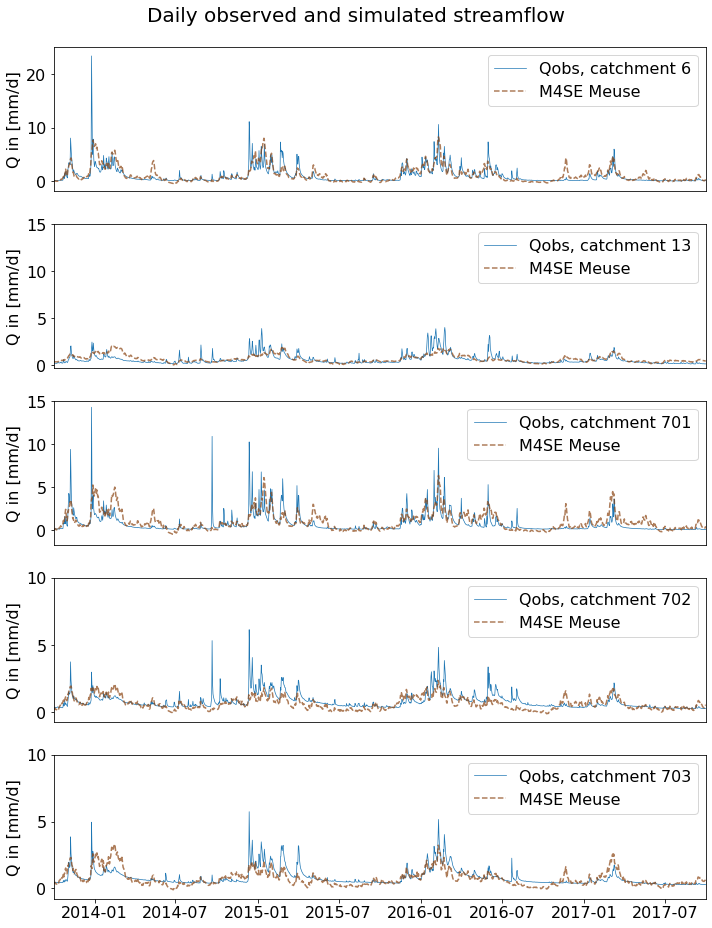

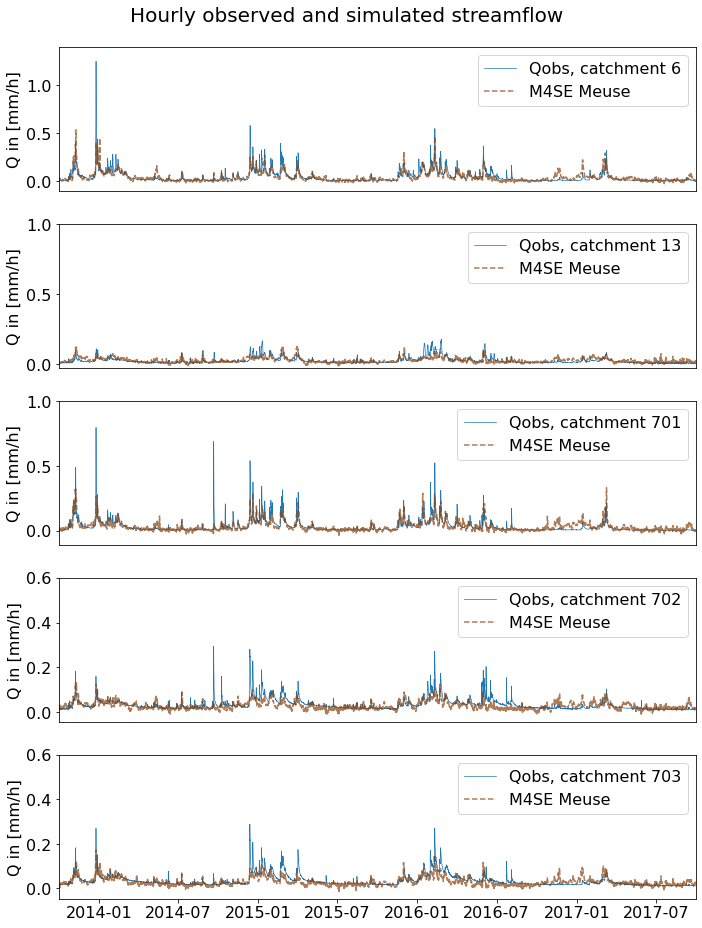

In [15]:
## Q in m3/s / m2 / 10**6 m2/mm2 * 1000 mm/m * 3600 s/h = mm/h * 24 h/d = mm/d
ylims = [25, 15, 15, 10, 10]
ylims_h = [1.4, 1, 1, 0.6, 0.6]

for freq in frequencies:
        
    fig, axes = plt.subplots(figsize=(10, 15), sharex=True) # 10, 15
    
    if freq == '1D':
        meuse_obs = meuse_obs_d
        wflow_sim = wflow_sim_d
        title = 'Daily observed and simulated streamflow'
    elif freq == '1H':
        meuse_obs = meuse_obs_h
        wflow_sim = wflow_sim_h
        title = 'Hourly observed and simulated streamflow'
        
    for i, catchm in enumerate(meuse_obs.catchments.values):        
        ax = plt.subplot(6, 1, i+1)
        # meuse obs
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        x = meuse_obs.time.values
        ax.plot(x, qobs, label=f'Qobs, catchment {catchm}', lw=0.7)
        
#         # wflow sim
#         qsim_w = wflow_sim.sel({'catchments':catchm}).\
#                 Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
#         x = wflow_sim.time.values
#         ax.plot(x, qsim_w, label=f'Q_{catchm}_wflow', alpha=0.7)
    
        
        # new loss lstm sim
        catchment = 'meuse_' + str(catchm)
        ds = new_loss_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
        qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
        x = qsim_l.datetime.values
        ax.plot(x, qsim_l, label=f'M4SE Meuse', color='saddlebrown', alpha=0.7, ls='--')
        
        plt.legend(fontsize=16)
        ax.set_title('')
        ax.set_ylabel('Q in [mm/d]' if freq=='1D' else 'Q in [mm/h]', fontsize=16)
        ax.set_xlim(left=pd.to_datetime('2013-10-01', format='%Y-%m-%d'), right=pd.to_datetime('2017-09-30', format='%Y-%m-%d'))
        ax.set_ylim(top=ylims[i] if freq == '1D' else ylims_h[i])
        
        if i < 4:
            ax.tick_params(labelcolor='none', axis='x', which='both', top=False, bottom=False, left=False, right=False)
            ax.get_xaxis().set_visible(False)
        ax.tick_params('both', labelsize=16)
            
    plt.suptitle(title, size=20, y=1)
    plt.tight_layout()
    plt.savefig(f'plots/time-series/meuse_{freq}_newloss')
    plt.show()
    

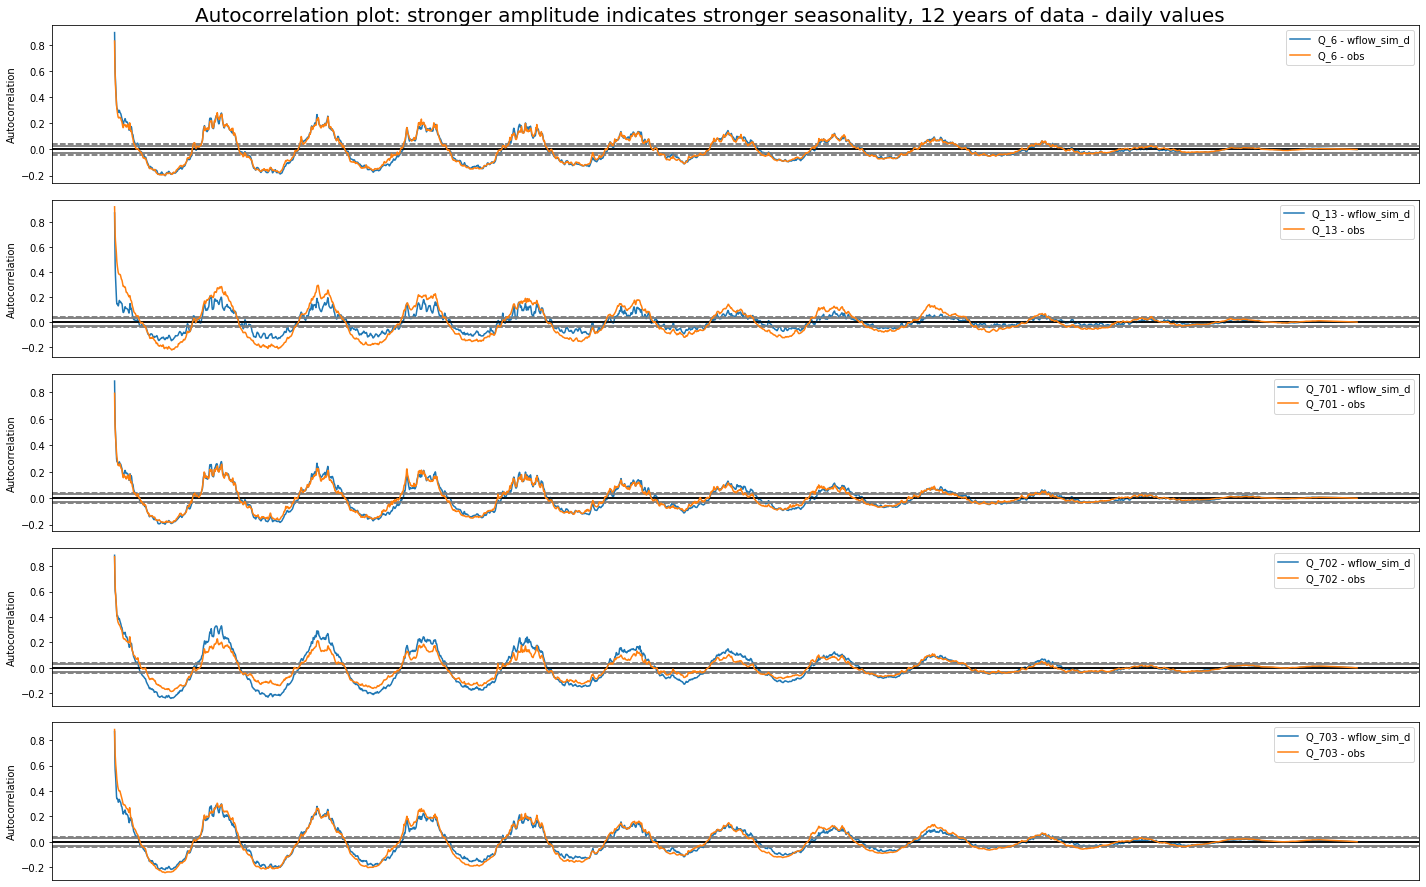

In [16]:
# autocorrelation plot --> shows seasonality

fig, axes = plt.subplots(figsize=(20, 15))
for i, catchm in enumerate(meuse_obs_d.catchments.values):

    ax = plt.subplot(6, 1, i+1)
    df = wflow_sim_d.sel({'catchments':catchm}).Qsim_m3s.to_dataframe()
    df = df.drop(columns='catchments')
    autocorrelation_plot(df, ax=ax, label=f'Q_{catchm} - wflow_sim_d') 
    
    df = meuse_obs_d.sel({'catchments':catchm}).Qobs_m3s.to_dataframe()
    df = df.drop(columns='catchments')
    autocorrelation_plot(df, ax=ax, label=f'Q_{catchm} - obs')
    plt.legend()
    
    if i < 5:
        ax.tick_params(labelcolor='none', axis='x', which='both', top=False, bottom=False, left=False, right=False)
        ax.get_xaxis().set_visible(False)
plt.suptitle('Autocorrelation plot: stronger amplitude indicates stronger seasonality, 12 years of data - daily values', size=20)
plt.tight_layout()
plt.show()

### Load or calculate metrics
- nested dictionarry: DICT[model][catchment_ID][freq]
    - model: wflow, lstm, M4SE (str)
    - catchment_ID: 6, 13, 701, 702, 703 (int)
    - freq: 1D, 1H (str)
    - gives dataframe with metrics as columns: NSE, KGE, Pearson-r, FHV, Peak-Timing, abs_error, rel_error, peaks, sim<obs, sim>obs  


- set repeat to true if you want to recalculate the metrics, otherwise metrics are loaded from pickle file

In [21]:
metrics = ['NSE', 'KGE', 'FHV', 'Peak-Timing']

repeat = False
if not os.path.isfile(meuse_dir + '/metrics_newloss.p') or repeat == True:
    metrics_dict = defaultdict(lambda: defaultdict(dict))

    for freq in frequencies:

        if freq == '1D':
            meuse_obs = meuse_obs_d
            wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
            wflow_sim = wflow_sim_h

        for i, catchm in enumerate(catchment_ids_obs):
            # get simulated streamflow lstm
            catchment = 'meuse_' + str(catchm)
            ds = lstm_results[catchment][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_l = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            # get simulated streamflow lstm - new loss
            catchment = 'meuse_' + str(catchm)
            ds = new_loss_results[catchment][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_ln = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_ln = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            # get simulated streamflow
            qsim = wflow_sim.sel({'catchments':catchm})['Qsim_m3s']
            qsim = qsim.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qsim = qsim.rename({'time': 'datetime'})

            # get observed streamflow
            qobs = meuse_obs.sel({'catchments':catchm})['Qobs_m3s']
            qobs = qobs.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qobs = qobs.rename({'time': 'datetime'})

            # convert to mm/h   ---   m3/s * 10**3 mmm/m * 3600 s/h / (10**6 * area)
            area = areas[i]
            qsim = qsim * 10**3 * 3600 / (area * 10**6)
            qobs = qobs * 10**3 * 3600 / (area * 10**6)

            # calculate metrics    
            metrics_w = calculate_metrics(qobs, qsim, metrics=metrics, resolution=freq)
            df_w = pd.DataFrame(data=metrics_w, 
                                    columns=list(metrics_w.keys()),
                                    index=[catchm])
            metrics_l = calculate_metrics(qobs_l, qsim_l, metrics=metrics, resolution=freq)
            df_l = pd.DataFrame(data=metrics_l, 
                                    columns=list(metrics_l.keys()),
                                    index=[catchm])
            metrics_ln = calculate_metrics(qobs_ln, qsim_ln, metrics=metrics, resolution=freq)
            df_ln = pd.DataFrame(data=metrics_ln, 
                                    columns=list(metrics_ln.keys()),
                                    index=[catchm])

            # calculate peak metrics
            peak_wflow = mean_peak_magnitude(qobs, qsim, resolution=freq)
            df_peak_w = pd.DataFrame(data=peak_wflow, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
            peak_lstm = mean_peak_magnitude(qobs_l, qsim_l, resolution=freq)
            df_peak_l = pd.DataFrame(data=peak_lstm, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
            peak_lstm_n = mean_peak_magnitude(qobs_ln, qsim_ln, resolution=freq)
            df_peak_ln = pd.DataFrame(data=peak_lstm_n, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
            df_w = df_w.join(other=df_peak_w)
            df_l = df_l.join(other=df_peak_l)
            df_ln = df_ln.join(other=df_peak_ln)
            
            metrics_dict['wflow'][catchm][freq] = df_w 
            metrics_dict['lstm'][catchm][freq] = df_l
            metrics_dict['M4SE'][catchm][freq] = df_ln
            
    # save to local drive
    pickle.dump({k: dict(v) for k, v in metrics_dict.items()}, Path(meuse_dir + '/metrics_newloss.p').open('wb'))
    print('Calculated metrics and stored in pickle file on drive.')
    metrics_dict
else:
    # load from local drive
    metrics_dict = pickle.load(Path(meuse_dir + '/metrics_newloss.p').open('rb'))
    print('Loaded metrics pickle file from drive')

# metrics_dict

Loaded metrics pickle file from drive


In [22]:
# example
metrics_dict['M4SE'][6]['1D']

,NSE,KGE,FHV,Peak-Timing,abs_error,rel_error,peaks,sim<obs,sim>obs
6,0.499926,0.71596,-8.619182,1.714286,5.148981,0.522474,7,7,0


### Calculate Signatures
- nested dictionarry: DICT[model][catchment_ID][freq][signature]
    - model: obs, lstm_no_stats, lstm_less_stats   (str)
    - catchment_ID: 6, 13, 701, 702, 703 (int)
    - freq: 1D, 1H (str)
    - signature: 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'q95', 'q5', 'q_mean', 'hfd_mean', 'slope_fdc', 'stream_elas', 'runoff_ratio'


- set repeat to true if you want to recalculate the signatures, otherwise signatures are loaded from pickle file


In [23]:
all_signatures = get_available_signatures()
all_signatures.remove('baseflow_index')

all_signatures

['high_q_freq',
 'high_q_dur',
 'low_q_freq',
 'low_q_dur',
 'zero_q_freq',
 'q95',
 'q5',
 'q_mean',
 'hfd_mean',
 'slope_fdc',
 'stream_elas',
 'runoff_ratio']

In [25]:
repeat=False
if not os.path.isfile(meuse_dir + '/signatures_newloss.p') or repeat==True:
    sign_dict = defaultdict(lambda: defaultdict(dict))
    for freq in frequencies:

        for i, catchm in enumerate(catchment_ids_obs):          
            if freq == '1D':
                meuse_obs = meuse_obs_d
                wflow_sim = wflow_sim_d
                c = 'meuse_' + str(catchm)
                f_precip = xr.DataArray(precip_era5.sel(basin=c).to_series().resample('1D').sum())
                      
            elif freq == '1H':
                meuse_obs = meuse_obs_h
                wflow_sim = wflow_sim_h
                c = 'meuse_' + str(catchm)
                f_precip = precip_era5.sel(basin=c)
                      
            
            # get simulated streamflow lstm
            ds = lstm_results[c][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_l = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            # get simultaed streamflow lstm - new loss
            ds = new_loss_results[c][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_ln = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_ln = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            # get simulated streamflow wflow
            qsim = wflow_sim.sel({'catchments':catchm})['Qsim_m3s']
            qsim = qsim.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qsim = qsim.rename({'time': 'datetime'})

            # get observed streamflow
            qobs = meuse_obs.sel({'catchments':catchm})['Qobs_m3s']
            qobs = qobs.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qobs = qobs.rename({'time': 'datetime'})

            # convert to mm/h   ---   m3/s * 10**3 mmm/m * 3600 s/h / (10**6 * area)
            area = areas[i]
            qsim = qsim * 10**3 * 3600 / (area * 10**6) * (24 if freq == '1D' else 1)
            qobs = qobs * 10**3 * 3600 / (area * 10**6) * (24 if freq == '1D' else 1)

            # clip predictions to 0
            qsim = xr.where(qsim < 0, 0, qsim)
            qsim_l = xr.where(qsim_l < 0, 0, qsim_l)
            qsim_ln = xr.where(qsim_ln < 0, 0, qsim_ln)

            # calculate signatures --> add loop through freq
            sign_dict['obs'][catchm][freq] = calculate_signatures(qobs, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
            sign_dict['wflow'][catchm][freq] = calculate_signatures(qsim, all_signatures,
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
            sign_dict['lstm'][catchm][freq] = calculate_signatures(qsim_l, all_signatures,
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
            sign_dict['M4SE'][catchm][freq] = calculate_signatures(qsim_ln, all_signatures,
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
                      
            # for baseflow index calculation, mask the array in the same places where obs has NaNs.
            masked_sim = qsim.copy()
            masked_sim[qobs.isnull()] = np.nan
            sign_dict['wflow'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
            masked_sim = qsim_l.copy()
            masked_sim[qobs_l.isnull()] = np.nan
            sign_dict['lstm'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
            masked_sim = qsim_ln.copy()
            masked_sim[qobs_ln.isnull()] = np.nan
            sign_dict['M4SE'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
                      
    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in sign_dict.items()}, Path(meuse_dir + '/signatures_newloss.p').open('wb'))
    print('Calculated signatures and stored in pickle file on drive.')

else:
    # load from local drive
    sign_dict = pickle.load(Path(meuse_dir + '/signatures_newloss.p').open('rb'))
    print('Loaded signatures pickle file from drive')   
    
# sign_dict

Loaded signatures pickle file from drive


### Show metrics & signatures in table and/or visualize

#### convert dictionarries with metrics and signatures to dataframes

In [27]:
def dict_to_df(model: str, results: dict, freqs: List[str]) -> pd.DataFrame:
    """Convert a nested dict into a MultiIndex DataFrame. """
    results = results[model].copy()
    for catchm in results.keys():
        for freq in freqs:
            keys = list(results[catchm][freq].keys())
            for key in keys:
                results[catchm][freq][key] = results[catchm][freq].pop(key)
    df = pd.DataFrame.from_dict({(model, catchm, freq): results[catchm][freq]
                                 for catchm in results.keys() 
                                 for freq in freqs},
                                orient='index')
    df = df.swaplevel(1, 2, axis=0)
    df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return df

def dict_to_df_metrics(model:str, results: dict, freqs: List[str]) -> pd.DataFrame:
    results = results[model].copy()
    for i, catchm in enumerate(results.keys()):
        for freq in freqs:
            df = results[catchm][freq]
            df = pd.concat({freq: df}, names=['freq'])
            df = pd.concat({model: df}, names=['model'])
            if i == 0:
                return_df = df
            else:
                return_df = return_df.append(df)
    return_df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return return_df

In [28]:
# create multiindex [model, freq, catchment] dataframe with metrics and one with signatures combined for all models

# metrics combined df
results_df_m_l = dict_to_df_metrics(models[0], metrics_dict, frequencies).sort_index()  
results_df_m_w = dict_to_df_metrics(models[1], metrics_dict, frequencies).sort_index()  
results_df_m_ln = dict_to_df_metrics(models[2], metrics_dict, frequencies).sort_index()  
results_df_m = pd.concat((results_df_m_ln, results_df_m_l, results_df_m_w), axis=0)

# signatures combined df
results_df_s = pd.concat([dict_to_df(model_name, sign_dict, frequencies)
                          for model_name in models]).sort_index()

# results_df_s
# results_df_m

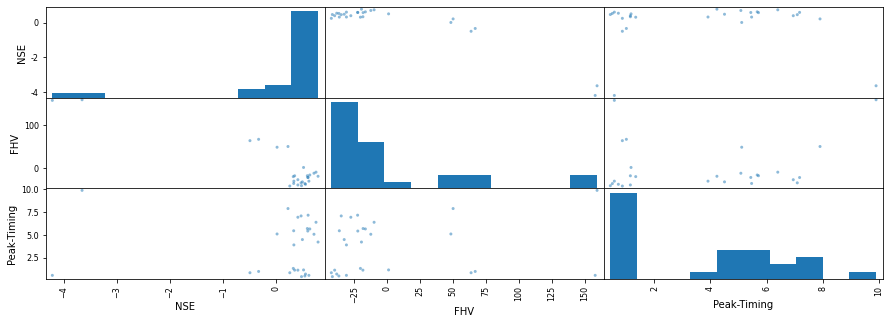

In [29]:
# results_df_m
scatter_matrix(results_df_m[['NSE', 'FHV', 'Peak-Timing']], figsize=(15, 5), diagonal='hist'); # diagonal='kde'

#### show table to compare metrics and signatures (median per model)

In [31]:
# metrics
# drop_cols = ['Alpha-NSE', 'Beta-NSE', 'MSE', 'RMSE', 'Pearson-r', 'FMS', 'FLV']

medians_m = results_df_m.groupby(['model', 'freq']).median()
medians_m['NSE_mean'] = results_df_m['NSE'].groupby(['model', 'freq']).mean()
medians_m['NSE<0'] = results_df_m['NSE'].groupby(['model', 'freq']).apply(lambda x: (x<0).sum())
medians_m['KGE<-0.41'] = results_df_m[['KGE']].groupby(['model', 'freq']).apply(lambda x: (x<-0.41).sum())
# medians_m.drop(columns=drop_cols, inplace=True)

display(medians_m.style.format('{:.3f}'))

#### compare metrics and signatures per catchment

In [33]:
# metrics
compare_m = results_df_m.swaplevel(i=-3, j=-1).sort_index()

# compare_m.drop(columns=drop_cols, inplace=True)
compare_m.style.format('{:.2f}')

In [34]:
# signatures
# high_q > 9 * mean Q
# low_q < 0.2 * mean Q
keep_cols = ['high_q_freq', 'high_q_dur', 'q95', 'hfd_mean', 'runoff_ratio']


compare_s = results_df_s.swaplevel(i=-3, j=-1).sort_index()

# hfd mean from hours to days for hourly timescale
compare_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] = compare_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] / 24

compare_s[keep_cols].style.format('{:.2f}')

In [35]:
custom_dict = {'wflow': 0, 'lstm': 1, 'M4SE': 2, 'obs': 3} 

# compare_s.sort_index(level=[-1], key=lambda x: x.map(custom_dict), inplace=True)
compare_s.sort_index(inplace=True)
compare_s

high_q_freq  high_q_dur   low_q_freq   low_q_dur  \
catchment freq model                                                     
6         1D   M4SE      6.333333    4.800000   107.000000   11.108108   
               lstm      3.666667    4.000000    84.000000    5.962264   
               obs      17.333333    2.064516    88.333333   10.605263   
               wflow     7.333333    1.933333    51.000000    8.615385   
          1H   M4SE     63.666667   32.692308  2082.666667   33.452675   
               lstm    212.666667   30.303030  1345.666667   16.607261   
               obs     402.000000   35.738095  2152.666667  119.317073   
               wflow   257.000000   27.676471   273.000000   72.523810   
13        1D   M4SE      0.000000         NaN    18.000000    4.285714   
               lstm      0.000000         NaN    21.666667    2.807692   
               obs       1.666667    1.666667     0.000000    2.750000   
               wflow    59.333333    5.116279   169.000000   24.714286   
          1H   M4SE      0.000000         NaN   327.000000   17.052632   
               lstm      7.666667   23.000000    95.000000    5.679245   
               obs      45.000000   22.500000     8.333333    5.523077   
               wflow  1398.333333   96.129630  4128.666667  392.547619   
701       1D   M4SE      0.333333    1.000000    96.333333   10.636364   
               lstm      6.666667    4.200000    55.000000    3.693878   
               obs      16.333333    2.333333    47.666667    6.926829   
               wflow    17.000000    2.333333    92.333333   27.133333   
          1H   M4SE     93.000000   27.210526  1605.000000   19.335347   
               lstm    305.000000   32.864865  1166.333333   13.445483   
               obs     406.333333   30.420000  1309.666667   69.951923   
               wflow   522.000000   45.926829  1939.000000  181.574468   
702       1D   M4SE      0.000000         NaN    37.666667    5.545455   
               lstm      0.000000         NaN     0.000000         NaN   
               obs       0.333333    1.000000     0.000000         NaN   
               wflow     2.000000    2.000000     0.000000         NaN   
          1H   M4SE      0.000000         NaN   258.666667   14.850000   
               lstm      0.000000         NaN     1.333333    1.200000   
               obs      15.666667   15.666667     0.000000         NaN   
               wflow    49.333333   15.818182     0.000000         NaN   
703       1D   M4SE      0.000000         NaN    33.666667    8.071429   
               lstm      0.000000         NaN     0.000000    1.000000   
               obs       0.333333    1.000000     0.000000         NaN   
               wflow     4.666667    1.416667     1.333333    5.000000   
          1H   M4SE      0.000000         NaN   187.000000    9.189873   
               lstm      0.000000         NaN     1.000000    1.000000   
               obs      10.333333    8.200000     0.000000         NaN   
               wflow   148.666667   24.318182     0.000000         NaN   

                      zero_q_freq       q95        q5    q_mean    hfd_mean  \
catchment freq model                                                          
6         1D   M4SE      0.111567  4.227102  0.000000  1.228861  121.000000   
               lstm      0.018480  3.715823  0.056749  0.998869  128.000000   
               obs       0.000000  3.890336  0.135516  1.073354  124.666667   
               wflow     0.000000  3.844967  0.170852  1.085137  124.000000   
          1H   M4SE      0.052932  0.144059  0.000000  0.043485  122.666667   
               lstm      0.000257  0.157061  0.006144  0.042310  128.263889   
               obs       0.000000  0.161385  0.005547  0.044748  125.416667   
               wflow     0.000000  0.137285  0.008025  0.039466  127.569444   
13        1D   M4SE      0.000684  1.444015  0.133462  0.628787  140.666667   
               lstm      0.006160  1.218366 

## Flow Duration Curves

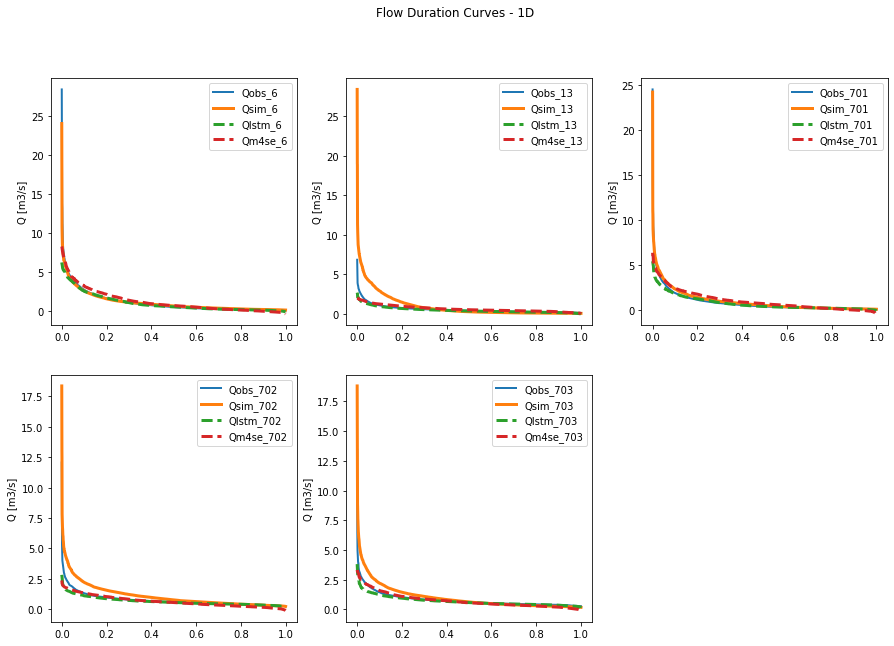

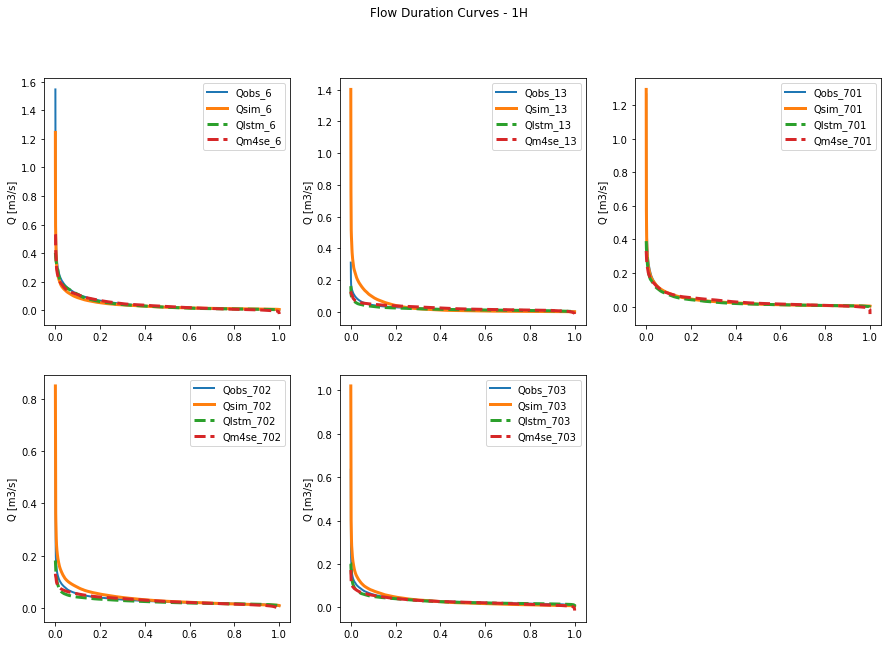

In [36]:
colors = [i for i in get_cmap('tab20b').colors]


for freq in frequencies:
    fig = plt.subplots(figsize=(15, 10))
    for i, catchm in enumerate(meuse_obs.catchments.values):

        if freq == '1D':
            meuse_obs = meuse_obs_d
            wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
            wflow_sim = wflow_sim_h

        ax = plt.subplot(2, 3, i+1)
        # get simulated streamflow
        qsim = wflow_sim.sel(time=slice(start_date, end_date))
        qsim = qsim.sel({'catchments':catchm}).\
                Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        
        # get observed streamflow
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)

        
        # lstm sim
        catchment = 'meuse_' + str(catchm)
        ds = lstm_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
        
        # new loss lstm
        catchment = 'meuse_' + str(catchm)
        ds = new_loss_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
        ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_ln = ds['qobs_sim'].values * (24 if freq == '1D' else 1)
        

        fdc = -np.sort(-qobs)
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Qobs_{catchm}', color='C0', lw=2)

        fdc = -np.sort(-qsim) 
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Qsim_{catchm}', color='C1', lw=3) # color=colors[i*4]
  
        fdc = -np.sort(-qsim_l)        
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Qlstm_{catchm}', color='C2', ls='--', lw=3)
  
        fdc = -np.sort(-qsim_ln)        
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Qm4se_{catchm}', color='C3', ls='--', lw=3)
        
        plt.ylabel('Q [m3/s]')
        plt.legend()
    plt.suptitle(f'Flow Duration Curves - {freq}')

C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_l

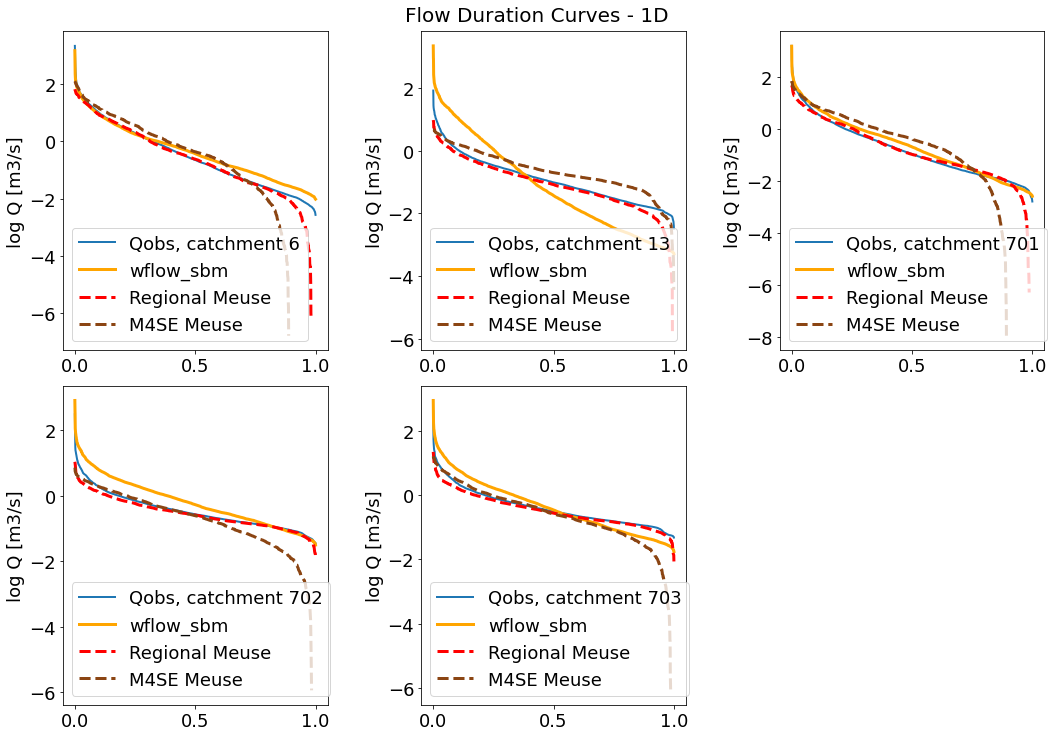

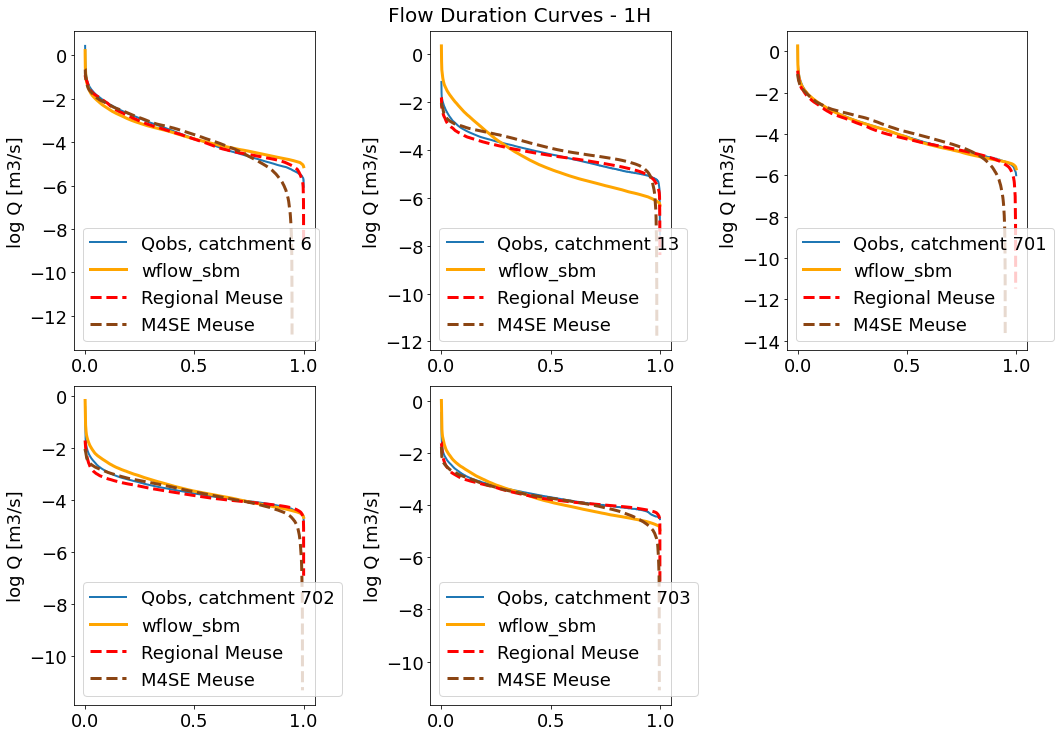

In [37]:
colors = [i for i in get_cmap('tab20b').colors]


for freq in frequencies:
    fig = plt.subplots(figsize=(15, 10))
    for i, catchm in enumerate(meuse_obs.catchments.values):

        if freq == '1D':
            meuse_obs = meuse_obs_d
            wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
            wflow_sim = wflow_sim_h

        ax = plt.subplot(2, 3, i+1)
        # get simulated streamflow
        qsim = wflow_sim.sel(time=slice(start_date, end_date))
        qsim = qsim.sel({'catchments':catchm}).\
                Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        
        # get observed streamflow
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)

        

        # lstm sim
        catchment = 'meuse_' + str(catchm)
        ds = lstm_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            ds = ds.sel(datetime=slice(start_date, end_date))
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_l = ds['qobs_sim'].values * (24 if freq == '1D' else 1)
        
        
        # new loss lstm
        catchment = 'meuse_' + str(catchm)
        ds = new_loss_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
        ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_ln = ds['qobs_sim'].values * (24 if freq == '1D' else 1)

        qobs_log = np.log(qobs)
        fdc = -np.sort(-qobs_log)
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'Qobs, catchment {catchm}', color='C0', lw=2)

        qsim_log = np.log(qsim)
        fdc = -np.sort(-qsim_log) 
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'wflow_sbm', color='orange', lw=3)  

        qsim_l_log = np.log(qsim_l)
        fdc = -np.sort(-qsim_l_log)        
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'Regional Meuse', color='red', ls='--', lw=3)
  
        qsim_ln_log = np.log(qsim_ln)
        fdc = -np.sort(-qsim_ln_log)        
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'M4SE Meuse', color='saddlebrown', ls='--', lw=3)
        
        plt.ylabel('log Q [m3/s]',  fontsize=18)
        ax.tick_params('both', labelsize=18)
        plt.legend( fontsize=18)
    plt.tight_layout()
    plt.suptitle(f'Flow Duration Curves - {freq}', y=1.02, fontsize=20)